In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [2]:
accepted_chars = '0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

char2idx = {"<PAD>": 0, "<UNK>": 1}
for i, char in enumerate(accepted_chars, start=2):
    char2idx[char] = i

def encode_url(url, mapping):
    return [mapping.get(c, mapping["<UNK>"]) for c in url]

def pad_sequence(seq, max_len, pad_value=0):
    seq = seq[:max_len]
    return seq + [pad_value] * (max_len - len(seq))

max_len = 250

# Load data
df = pd.read_csv('malicious_phish.csv')

# Lowercase URLs
df['url_clean'] = df['url'].str.lower()

# Encode URLs as sequences of ints
df['encoded'] = df['url_clean'].apply(lambda u: encode_url(u, char2idx))

# Features (X) and labels (y)
X = df['encoded'].to_list()      # list of int sequences
y = df['type'].to_list()         # 4-class labels as strings

# Label encoding (multi-class)
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

# Train/test split 
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# Padding
X_train = np.array([pad_sequence(seq, max_len) for seq in X_train_raw], dtype='int32')
X_test  = np.array([pad_sequence(seq, max_len) for seq in X_test_raw], dtype='int32')

y_train = np.array(y_train)
y_test  = np.array(y_test)

num_classes = len(le.classes_)   # should be 4
vocab_size = len(char2idx)       # for the Embedding layer later
print("Classes:", le.classes_)
print("num_classes:", num_classes, "vocab_size:", vocab_size)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


Classes: ['benign' 'defacement' 'malware' 'phishing']
num_classes: 4 vocab_size: 70
X_train shape: (520952, 250) X_test shape: (130239, 250)


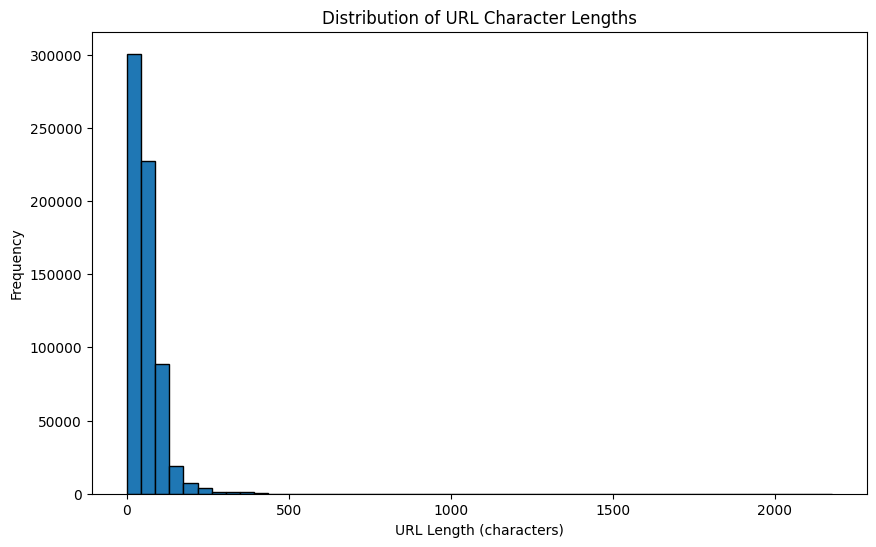

In [3]:
# Finding max length for padding: 
df['length'] = df['encoded'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=50, edgecolor='black')
plt.title("Distribution of URL Character Lengths")
plt.xlabel("URL Length (characters)")
plt.ylabel("Frequency")
plt.show()

In [4]:
# Model Training 
vocab_size = len(char2idx)       
embedding_dim = 32               
num_classes = len(le.classes_)   

model = Sequential([
    Embedding(
        input_dim=vocab_size,      
        output_dim=embedding_dim, 
    ),
   
    Conv1D(
        filters=64,                
        kernel_size=5,             
        activation='relu' 
    ),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax') 
])
model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, 
    y_train,
    epochs=5,  
    batch_size=256, 
    validation_split=0.2, 
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

2026-01-30 15:21:50.849030: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-30 15:21:50.849150: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-01-30 15:21:50.849210: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-01-30 15:21:50.849251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-30 15:21:50.849303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2026-01-30 15:21:51.505109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 582s 357ms/step - accuracy: 0.9302 - loss: 0.2078 - val_accuracy: 0.9601 - val_loss: 0.1241
Epoch 2/5
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 535s 328ms/step - accuracy: 0.9639 - loss: 0.1154 - val_accuracy: 0.9668 - val_loss: 0.1048
Epoch 3/5
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 501s 308ms/step - accuracy: 0.9681 - loss: 0.1016 - val_accuracy: 0.9681 - val_loss: 0.1006
Epoch 4/5
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 459s 282ms/step - accuracy: 0.9700 - loss: 0.0949 - val_accuracy: 0.9709 - val_loss: 0.0929
Epoch 5/5
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 445s 273ms/step - accuracy: 0.9716 - loss: 0.0905 - val_accuracy: 0.9696 - val_loss: 0.0946


In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", accuracy) 



4070/4070 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9706 - loss: 0.0958
Test Accuracy: 0.9706078767776489
